## Generating point cloud

DO NOT RUN if results are already present, as it takes 40 minutes

In [ ]:
from pyodm import Node
from os import listdir, path

In [ ]:
n = Node('localhost', 3000)

In [ ]:
prefix = '../images/original'
files = [path.sep.join([prefix, f]) for f in listdir(prefix)]

In [ ]:
task = n.create_task(files, {'dsm': True})
task.wait_for_completion()

In [ ]:
task.download_assets("/media/antonio/Ubuntail/Dropbox/education/phd/courses/processamento_imagens/assignments/final/pyodm")

## Visualizing point cloud

In [7]:
import laspy
import open3d as o3d
import numpy as np
from os import listdir, path

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
pc_data_dir = '/media/antonio/Ubuntail/Dropbox/education/phd/courses/processamento_imagens/assignments/final/pyodm/entwine_pointcloud/ept-data'

In [9]:
points = None
for fname in listdir(pc_data_dir):
    pc = laspy.read(path.sep.join([pc_data_dir, fname]))
    point_data = np.stack([pc.X, pc.Y, pc.Z], axis=0).transpose((1, 0))
    if points is None:
        points = point_data
    else:
        points = np.concatenate([points, point_data])
points -= np.min(points, axis=0)
points = points.astype(np.float32)       

In [11]:
surface = o3d.geometry.PointCloud()
surface.points = o3d.utility.Vector3dVector(points)
o3d.visualization.draw_geometries([surface])

## Generate Depth-Map from Point-Cloud

In [1]:
from point_cloud import get_depth_map
import matplotlib.pyplot as plt

In [2]:
def show(img, plt_size=(16, 10), cmap=None):
    fig = plt.figure(figsize=plt_size)
    plt.imshow(img, cmap=cmap if cmap is not None else (None if len(img.shape) == 3 else 'gray'))

In [5]:
depth_map = get_depth_map(pc_data_dir, (500, 625))

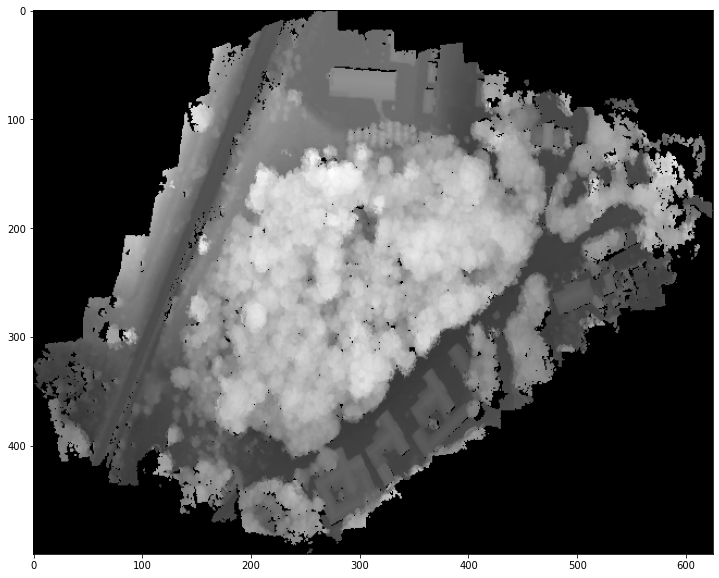

In [6]:
show(depth_map)